## Project DataDrivenBuildingInSpain_Ferrari

In this project, I'm trying predict the *indoor room* temperature by means of correlation and machine learning methods from the data of *sun irradiation*, *outdoor temperature*, *room lighting* and *outdoor humidity* of a building located in **Seville** ( Spain ).

First of all, I'm gonna import all the required modules.

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

With the following command I avoid the warning caused by the attempt of changing the value of objects in data frames.

In [7]:
pd.set_option('mode.chained_assignment', None)

Now, I enter the folder where the data I need are located.

In [8]:
InputFolder = r"C:\Users\Mirko\Desktop\DataDrivenBuilding_Ferrari"
os.chdir(InputFolder)

Now I'm going to read the initial data from the .csv file found on the Internet and convert it into a dataframe. I'm also changing the format of index to Date Time format. 
From all the data, I want to select days from 15/03/2012 to 22/03/2012 ( one week ).

In [9]:
ExcelFileName = "BuildingDataSet.csv"
Path_ExcelFile = os.path.join(InputFolder,ExcelFileName)
DF_StartingDataSet = pd.read_csv(Path_ExcelFile,sep=",",index_col=0)
PreviousIndex = DF_StartingDataSet.index
NewParsedIndex = pd.to_datetime(PreviousIndex)  
DF_StartingDataSet.index = NewParsedIndex 
DF_TargetDataSet = DF_StartingDataSet["15-03-2012":"22-03-2012"]
DF_TargetDataSet.describe() 

,Temperature_Comedor_Sensor,Temperature_Habitacion_Sensor,Weather_Temperature,CO2_Comedor_Sensor,CO2_Habitacion_Sensor,Humedad_Comedor_Sensor,Humedad_Habitacion_Sensor,Lighting_Comedor_Sensor,Lighting_Habitacion_Sensor,Precipitacion,...,Meteo_Exterior_Sol_Oest,Meteo_Exterior_Sol_Est,Meteo_Exterior_Sol_Sud,Meteo_Exterior_Piranometro,Exterior_Entalpic_1,Exterior_Entalpic_2,Exterior_Entalpic_turbo,Temperature_Exterior_Sensor,Humedad_Exterior_Sensor,Day_Of_Week
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,...,768.000000,768.000000,768.000000,768.000000,768.0,768.0,768.0,768.000000,768.000000,768.000000
mean,17.677122,17.331479,12.697657,206.954626,210.571919,42.633959,45.909001,27.729186,39.580455,0.121094,...,15322.247302,11232.182703,23736.192727,201.402311,0.0,0.0,0.0,14.969838,57.607838,3.998785
std,3.267742,3.164606,3.397326,7.259906,17.716853,6.706208,8.288114,25.562586,42.404370,0.326449,...,27542.487090,21190.599104,35573.475920,292.517196,0.0,0.0,0.0,3.806013,14.863722,1.871441
min,11.352000,11.076000,4.000000,197.664000,199.179000,27.084000,29.594700,11.165300,11.507300,0.000000,...,0.000000,0.000000,0.000000,-4.034670,0.0,0.0,0.0,9.223330,22.728000,1.000000
25%,15.313150,14.987650,9.000000,202.059000,204.181000,36.782675,40.844975,11.588700,13.428000,0.000000,...,0.000000,0.000000,0.000000,-3.250670,0.0,0.0,0.0,11.639850,48.065350,2.766668
50%,18.015000,17.733000,15.000000,205.355000,207.344000,43.328000,46.692000,11.784700,14.499650,0.000000,...,0.000000,0.000000,0.000000,-1.209335,0.0,0.0,0.0,14.383000,61.205350,4.000000
75%,20.113675,19.655500,15.000000,210.677500,211.437500,47.092700,50.465300,31.065650,43.142975,0.000000,...,14435.400000,9519.100000,47117.675000,416.794750,0.0,0.0,0.0,17.420000,67.524000,5.300002
max,24.192000,23.512000,18.000000,249.227000,463.317000,60.957300,62.594700,110.693000,162.965000,1.000000,...,94978.000000,82001.900000,95627.900000,923.307000,0.0,0.0,0.0,25.713300,83.805300,7.000000


Now I'm selecting specific columns of the DataFrame so as to correlate target and features. In this case, I'm choosing indoor temperature, sun irradiance, outdoor temperature, room lighting and outdoor humidity.

In [10]:
DF_Choosen = DF_TargetDataSet[['Temperature_Habitacion_Sensor','Meteo_Exterior_Piranometro','Temperature_Exterior_Sensor','Lighting_Habitacion_Sensor','Humedad_Exterior_Sensor']]  
DF_Choosen.describe()
DF_Choosen.rename(columns = {"Temperature_Habitacion_Sensor":"Indoor Room Temperature","Meteo_Exterior_Piranometro":"Sun Irradiance","Temperature_Exterior_Sensor":"Outdoor Temperature","Lighting_Habitacion_Sensor":"Room Lighting","Humedad_Exterior_Sensor":"Outdoor Humidity"},inplace = True) 
DF_Choosen["Sun Irradiance"][DF_Choosen["Sun Irradiance"]<0] = 0  

To create lagged features, I first make a copy of my selected DataFrame. Then, defining and using a proper function, I will create the lagged features for sun irradiation, outdoor temperature and indoor room temperature.

In [12]:
DF_Lagged = DF_Choosen.copy() 

def lag_feature(DF,ColumnName,LagInterval):    
        if(ColumnName=="Sun Irradiance"):
            for i in range(3,LagInterval+1):
                NewColumnName = ColumnName+" -"+str(i)+"hr"
                DF[NewColumnName]=(DF[ColumnName]).shift(i*4)
        elif(ColumnName=="Outdoor Temperature"):
            for i in range(1,LagInterval-1):
                NewColumnName = ColumnName+" -"+str(i)+"hr"
                DF[NewColumnName]=(DF[ColumnName]).shift(i*4)
        elif(ColumnName=="Indoor Room Temperature"):
            for i in range(2,LagInterval-1,2):
                NewColumnName = ColumnName+" "+str(i*15)+"minutes before"
                DF[NewColumnName]=(DF[ColumnName]).shift(i)
        return DF   

DF_Lagged = lag_feature(DF_Lagged,"Sun Irradiance",6)
DF_Lagged = lag_feature(DF_Lagged,"Outdoor Temperature",6)
DF_Lagged = lag_feature(DF_Lagged,"Indoor Room Temperature",6)
DF_Lagged.dropna(inplace=True)
# To describe my lagged DataFrame.
DF_Lagged.describe()

,Indoor Room Temperature,Sun Irradiance,Outdoor Temperature,Room Lighting,Outdoor Humidity,Sun Irradiance -3hr,Sun Irradiance -4hr,Sun Irradiance -5hr,Sun Irradiance -6hr,Outdoor Temperature -1hr,Outdoor Temperature -2hr,Outdoor Temperature -3hr,Outdoor Temperature -4hr,Indoor Room Temperature 30minutes before,Indoor Room Temperature 60minutes before
count,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000
mean,17.269158,209.607826,15.036208,40.424548,57.259919,209.607826,209.607826,209.607826,209.588809,15.032309,15.025563,15.014919,15.000521,17.276891,17.284275
std,3.195545,293.696608,3.847391,42.817963,14.960144,293.696608,293.696608,293.696608,293.709846,3.849533,3.852656,3.856609,3.860468,3.196080,3.196868
min,11.076000,0.000000,9.223330,11.507300,22.728000,0.000000,0.000000,0.000000,0.000000,9.223330,9.223330,9.223330,9.223330,11.076000,11.076000
25%,14.874000,0.000000,11.604000,13.428000,47.600025,0.000000,0.000000,0.000000,0.000000,11.604000,11.604000,11.604000,11.604000,14.874000,14.874000
50%,17.586700,3.472335,14.564000,15.062000,60.912000,3.472335,3.472335,3.472335,2.875000,14.564000,14.564000,14.540350,14.454650,17.609000,17.624300
75%,19.686500,433.602500,17.531850,47.017975,67.067325,433.602500,433.602500,433.602500,433.602500,17.531850,17.531850,17.531850,17.531850,19.686500,19.686500
max,23.512000,923.307000,25.713300,162.965000,83.805300,923.307000,923.307000,923.307000,923.307000,25.713300,25.713300,25.713300,25.713300,23.512000,23.512000


With the next sequence of commands, I'm trying to see if there is any strong **correlation** between the different element of the DataFrame.

In [13]:
DF_Lagged.corr()

,Indoor Room Temperature,Sun Irradiance,Outdoor Temperature,Room Lighting,Outdoor Humidity,Sun Irradiance -3hr,Sun Irradiance -4hr,Sun Irradiance -5hr,Sun Irradiance -6hr,Outdoor Temperature -1hr,Outdoor Temperature -2hr,Outdoor Temperature -3hr,Outdoor Temperature -4hr,Indoor Room Temperature 30minutes before,Indoor Room Temperature 60minutes before
Indoor Room Temperature,1.000000,0.196430,0.865930,0.080601,-0.750835,0.533422,0.572371,0.573599,0.543339,0.898595,0.894491,0.856404,0.791515,0.996217,0.985519
Sun Irradiance,0.196430,1.000000,0.454138,0.933885,-0.212624,0.556869,0.308156,0.064673,-0.146172,0.253257,0.039289,-0.160217,-0.322620,0.118402,0.040696
Outdoor Temperature,0.865930,0.454138,1.000000,0.303360,-0.671824,0.765620,0.750769,0.684301,0.579638,0.971662,0.893826,0.778973,0.640542,0.834565,0.795435
Room Lighting,0.080601,0.933885,0.303360,1.000000,-0.135387,0.333612,0.086304,-0.119875,-0.268342,0.091200,-0.112656,-0.283290,-0.404655,0.001968,-0.072806
Outdoor Humidity,-0.750835,-0.212624,-0.671824,-0.135387,1.000000,-0.345708,-0.346709,-0.323347,-0.281903,-0.676515,-0.663862,-0.637490,-0.601546,-0.743723,-0.734059
Sun Irradiance -3hr,0.533422,0.556869,0.765620,0.333612,-0.345708,1.000000,0.929676,0.775066,0.556891,0.721288,0.617338,0.456997,0.258424,0.496654,0.450704
Sun Irradiance -4hr,0.572371,0.308156,0.750769,0.086304,-0.346709,0.929676,1.000000,0.929676,0.775077,0.765918,0.721954,0.618678,0.459206,0.556070,0.529822
Sun Irradiance -5hr,0.573599,0.064673,0.684301,-0.119875,-0.323347,0.775066,0.929676,1.000000,0.929680,0.751075,0.766548,0.723187,0.620724,0.575585,0.568755
Sun Irradiance -6hr,0.543339,-0.146172,0.579638,-0.268342,-0.281903,0.556891,0.775077,0.929680,1.000000,0.684640,0.751700,0.767704,0.725087,0.560039,0.569977
Outdoor Temperature -1hr,0.898595,0.253257,0.971662,0.091200,-0.676515,0.721288,0.765918,0.751075,0.684640,1.000000,0.971760,0.894301,0.780078,0.885095,0.862392


In the next plot, I can show visually the strength of the correlations.

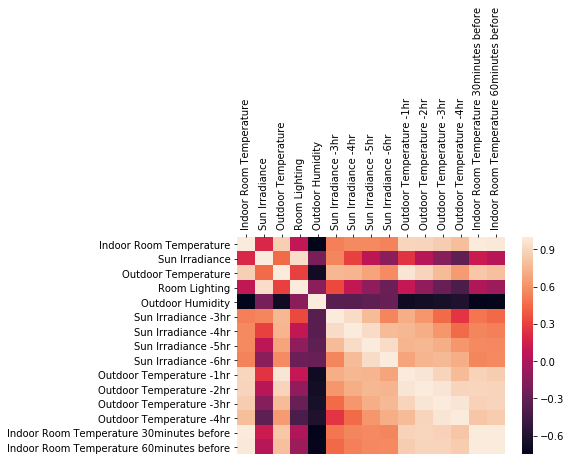

In [14]:
fig = plt.figure("Figure for providing insight about Correlations")
plot = fig.add_axes()
plot = sns.heatmap(DF_Lagged.corr(), annot = False)
plot.xaxis.tick_top() 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

I'm now introducing a function to *normalize* the data and eliminate the problem of different unit. 

In [15]:
def normalize(DF):
    return (DF-DF.min())/(DF.max()-DF.min())

I'm now plotting some specific columns of the normalized DataFrame.
About this next plot, something can be noticed:

1) the indoor room temperature increases w.r.t. outdoor temperature almost in real time while it takes time for sun irradiation to heat up the room, therefore sun irradiation has its peak earlier than room indoor temperature; 

2) in some period, sun irradiance is irregular. This is probably due to rainy or cloudy days;  

3) during night time, sun irradiation is nill.


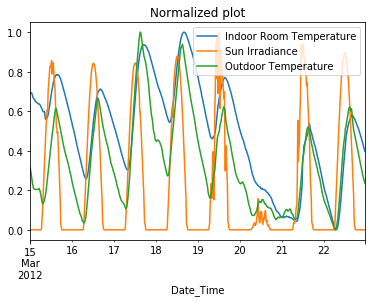

In [16]:
NormDF=normalize(DF_Choosen)
PlotDF=NormDF[["Indoor Room Temperature","Sun Irradiance","Outdoor Temperature"]]
PlotDF.plot()
plt.title("Normalized plot")
plt.show()

I can now add some time-related features like hour, day of the week, day or night or also weekend.

In [18]:
DF_Lagged['Hour'] = DF_Lagged.index.hour
DF_Lagged['Day Of The Week'] = DF_Lagged.index.dayofweek
DF_Lagged['Day Or Night'] = np.where((DF_Lagged['Hour'] >= 6)&(DF_Lagged['Hour'] <= 17), 1, 0)

def WeekendFinder(day):
    if (day == 0 or day == 1):
        weekend = 1
    else:
        weekend = 0
    return weekend 

DF_Lagged['Weekend'] = [WeekendFinder(s) for s in DF_Lagged['Day Of The Week']]
DF_Lagged.dropna(inplace = True)

*Day or night* is 1 if it's day time. 

In [19]:
DF_Lagged.head()

,Indoor Room Temperature,Sun Irradiance,Outdoor Temperature,Room Lighting,Outdoor Humidity,Sun Irradiance -3hr,Sun Irradiance -4hr,Sun Irradiance -5hr,Sun Irradiance -6hr,Outdoor Temperature -1hr,Outdoor Temperature -2hr,Outdoor Temperature -3hr,Outdoor Temperature -4hr,Indoor Room Temperature 30minutes before,Indoor Room Temperature 60minutes before,Hour,Day Of The Week,Day Or Night,Weekend
Date_Time,,,,,,,,,,,,,,,,,,,
2012-03-15 06:00:00,18.8607,0.00000,12.2227,11.7033,71.2800,0.0,0.0,0.0,0.0,12.6680,12.5873,12.5907,12.6680,18.9447,19.0000,6,3,1,0
2012-03-15 06:15:00,18.7953,0.00000,12.0147,12.1747,70.9653,0.0,0.0,0.0,0.0,12.6380,12.5967,12.5907,12.6267,18.9207,18.9900,6,3,1,0
2012-03-15 06:30:00,18.7267,6.12933,11.7967,20.1000,70.4773,0.0,0.0,0.0,0.0,12.5220,12.6067,12.5933,12.6133,18.8607,18.9447,6,3,1,0
2012-03-15 06:45:00,18.6720,41.16070,11.5727,21.3267,70.1413,0.0,0.0,0.0,0.0,12.3907,12.6367,12.5900,12.6033,18.7953,18.9207,6,3,1,0
2012-03-15 07:00:00,18.6067,83.40000,11.4327,23.0627,69.5067,0.0,0.0,0.0,0.0,12.2227,12.6680,12.5873,12.5907,18.7267,18.8607,7,3,1,0


//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Now I've to split the DataFrame in target and features. As target I want to choose the indoor room temperature.

In [21]:
DF_Target = DF_Lagged["Indoor Room Temperature"]
DF_Features = DF_Lagged.drop("Indoor Room Temperature",axis=1)

I'm now creating a training dataset for *machine learning* and providing an independent testset which follows same probabilistic distribution of the training one.


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(DF_Features,DF_Target,test_size=0.2,random_state=41234)

I'm now implementing *linear regression* technique.

In [23]:
from sklearn import linear_model 
linear_reg = linear_model.LinearRegression()

Now I want to train my model.

In [24]:
linear_reg.fit(X_train,Y_train)
Predicted_linearReg_split = linear_reg.predict(X_test)
Predicted_DF_linearReg_split = pd.DataFrame(Predicted_linearReg_split, index=Y_test.index, columns=["Indoor Room Temperature Prediction_LR"])
Predicted_DF_linearReg_split = Predicted_DF_linearReg_split.join(Y_test)
LearnedDataset = pd.DataFrame(Predicted_DF_linearReg_split).dropna()

I want now to plot the learned Dataset in order to verify the quality of the prediction.
From the plot it can be noticed how well the prediction has been made.

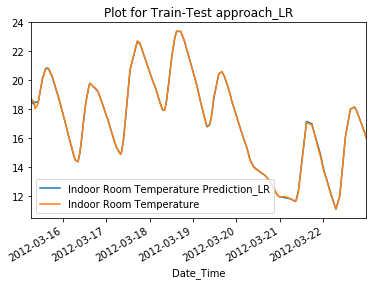

In [25]:
LearnedDataset.plot()
plt.title("Plot for Train-Test approach_LR")
plt.show()

One can already see only by graphical inspection how much the prediction sticks with the real values. Now I want to calculate how accurate the prediction is. 

In [26]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [27]:
R2_linearReg_split = r2_score(Y_test,Predicted_linearReg_split) 
MAE_linearReg_split = mean_absolute_error(Y_test,Predicted_linearReg_split)
MSE_linearReg_split = mean_squared_error(Y_test,Predicted_linearReg_split)

Let's print the results. Perfectly accurate model gives R2 value equal to 1.

In [28]:
print "The R2_score is "+str(R2_linearReg_split)
print "The mean absoulute error is "+str(MAE_linearReg_split)
print "The mean squared error is "+str(MSE_linearReg_split)

The R2_score is 0.999609207501
The mean absoulute error is 0.0366705017666
The mean squared error is 0.00352308739336


I'm now implementing K-fold cross-validation approach, in order to test the performances of the machine learning model.


In [29]:
from sklearn.model_selection import cross_val_predict

In [30]:
Predicted_linearReg_CV = cross_val_predict(linear_reg,DF_Features,DF_Target,cv=10)
Predicted_DF_linearReg_CV=pd.DataFrame(Predicted_linearReg_CV, index = DF_Target.index,columns=["Indoor Room Temperature Prediction_CV"])
Predicted_DF_linearReg_CV = Predicted_DF_linearReg_CV.join(DF_Target)

I want now to plot the learned Dataset in order to verify the quality of the prediction.
From the plot it can be noticed how well the prediction has been made.

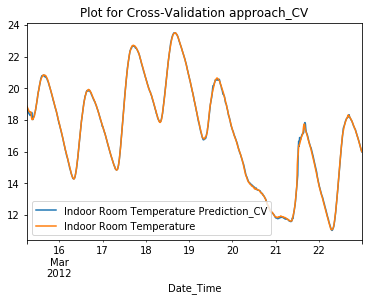

In [31]:
Predicted_DF_linearReg_CV.plot()
plt.title("Plot for Cross-Validation approach_CV")
plt.show()

As in the previous case, also here the model sticks very well the real values. Now I want to calculate how accurate the prediction is in this case.

In [32]:
R2_linearReg_CV = r2_score(Predicted_linearReg_CV,DF_Target)
MAE_linearReg_CV = mean_absolute_error(Predicted_linearReg_CV, DF_Target)
MSE_linearReg_CV = mean_squared_error(Predicted_linearReg_CV, DF_Target)

Let's print the results.

In [33]:
print "The R2_score is "+str(R2_linearReg_CV)
print "The mean absoulute error is "+str(MAE_linearReg_CV)
print "The mean squared error is "+str(MSE_linearReg_CV)

The R2_score is 0.999253821756
The mean absoulute error is 0.0468676810101
The mean squared error is 0.00760000443016


The first way of training the model gives a better result. Also this second one is very good though.

I'm now implementing Random Forest regression technique.

In [35]:
from sklearn.ensemble import RandomForestRegressor
reg_RF = RandomForestRegressor()
Predicted_RF_CV = cross_val_predict(reg_RF,DF_Features,DF_Target,cv=10) 
Predicted_DF_RF_CV=pd.DataFrame(Predicted_RF_CV, index = DF_Target.index,columns=["Indoor Room Temperature Prediction_CV"])
Predicted_DF_RF_CV = Predicted_DF_RF_CV.join(DF_Target).dropna()

I want now to plot the learned Dataset in order to verify the quality of the prediction.

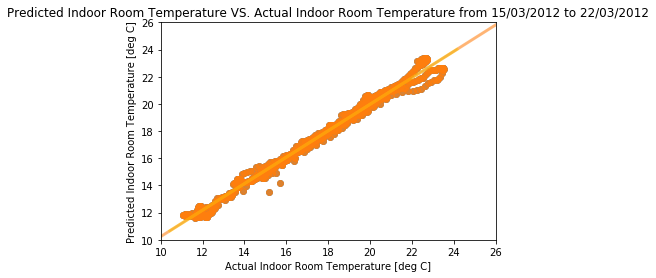

In [37]:
Fig = plt.figure("Actual Vs Prediction with Random Forest")
ax1 = Fig.add_subplot(111)
plot = sns.regplot(x="Indoor Room Temperature", y="Indoor Room Temperature Prediction_CV",
                   data=Predicted_DF_RF_CV,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Predicted Indoor Room Temperature VS. Actual Indoor Room Temperature from 15/03/2012 to 22/03/2012')
plot.set_xlim([10,26])                                                                  
plot.set_ylim([10,26])                   
plot.set_xlabel('Actual Indoor Room Temperature [deg C]')
plot.set_ylabel('Predicted Indoor Room Temperature [deg C]')
regline = plot.get_lines()[0];
regline.set_color('yellow')
plt.show(0)

Also in this case predictions are pretty accurate, except from few points. Now I want to calculate how accurate the prediction are in this case.

In [38]:
R2_RF_CV = r2_score(Predicted_RF_CV,DF_Target)
MAE_RF_CV = mean_absolute_error(Predicted_RF_CV,DF_Target)
MSE_RF_CV = mean_squared_error(Predicted_RF_CV,DF_Target)

Let's print the results.

In [39]:
print "\nThe R2_score is: "+str(R2_RF_CV)
print "The Mean absoulute error is: "+str(MAE_RF_CV)
print "The Mean squared error is: "+str(MSE_RF_CV)


The R2_score is: 0.986928444184
The Mean absoulute error is: 0.244390669739
The Mean squared error is: 0.127767552089


In this case we get the worst result, which still is almost perfect.

I want now to use continuous learning.

In [40]:
DF_IndoorTemperaturePrediction = pd.DataFrame(index = DF_Lagged.index)
Period_of_training = pd.Timedelta(4, unit ="d")
FirstTimeStamp_measured = DF_Lagged.index[0]
LastTimeStamp_measured = DF_Lagged.index[-1] 

Let's se now the beginning of the prediction period, which comes after a period of training for the model.

In [41]:
FirstTimeStamp_toPredict = FirstTimeStamp_measured + Period_of_training

The training starts at the first measure we have, and ends at the beggining of the prediction.

In [42]:
Training_startTimeStamp = FirstTimeStamp_measured
Trainig_endTimeStamp = FirstTimeStamp_toPredict                                             
TimeStamp_toPredict = FirstTimeStamp_toPredict

With the next command I'll remove from the DataFrame all the measurement taken before the beginning of the predictions.

In [43]:
DF_IndoorTemperaturePrediction = DF_IndoorTemperaturePrediction.truncate(before = Trainig_endTimeStamp) 

It's now time to train the model, and create a DataFrame comparing actual values and predictions. First I use linear regression.

In [44]:
while (TimeStamp_toPredict < LastTimeStamp_measured): 
    DF_feature_train = DF_Features.truncate(before = Training_startTimeStamp, after = Trainig_endTimeStamp)        
    DF_target_train = DF_Target.truncate(before = Training_startTimeStamp, after = Trainig_endTimeStamp)
    DF_feature_test = DF_Features.loc[TimeStamp_toPredict].values.reshape(1,-1)
    DF_target_test = DF_Target.loc[TimeStamp_toPredict]
    linear_reg.fit(DF_feature_train,DF_target_train)
    Predicted_Temperature = linear_reg.predict(DF_feature_test)
    DF_IndoorTemperaturePrediction.loc[TimeStamp_toPredict,"Predicted"] = Predicted_Temperature
    DF_IndoorTemperaturePrediction.loc[TimeStamp_toPredict,"Real"] = DF_target_test
    TimeStamp_toPredict = TimeStamp_toPredict + pd.Timedelta(15, unit = "m")
    Trainig_endTimeStamp = Trainig_endTimeStamp + pd.Timedelta(15, unit = "m")
    Training_startTimeStamp = Training_startTimeStamp + pd.Timedelta(15, unit = "m")
    
DF_IndoorTemperaturePrediction.dropna(inplace = True)

Let's see the R2 value of this case.

In [45]:
R2_score_continuous_linearReg = r2_score(DF_IndoorTemperaturePrediction[["Real"]],DF_IndoorTemperaturePrediction[["Predicted"]])
print("R2 value: "+str(R2_score_continuous_linearReg))

R2 value: 0.998685652885


As one can see, the predictions are very accurate. Let's see some of them, to compare with the actual values.

In [48]:
DF_IndoorTemperaturePrediction.head()

,Predicted,Real
Date_Time,,
2012-03-19 06:00:00,17.552996,17.5080
2012-03-19 06:15:00,17.414753,17.4167
2012-03-19 06:30:00,17.262400,17.2840
2012-03-19 06:45:00,17.187451,17.1513
2012-03-19 07:00:00,17.063500,17.0500


In [49]:
DF_IndoorTemperaturePrediction.tail()

,Predicted,Real
Date_Time,,
2012-03-22 22:30:00,16.486395,16.4973
2012-03-22 22:45:00,16.383050,16.3847
2012-03-22 23:00:00,16.255374,16.2967
2012-03-22 23:15:00,16.131800,16.1993
2012-03-22 23:30:00,16.032098,16.1033


I'm now plotting the behaviour of this model.

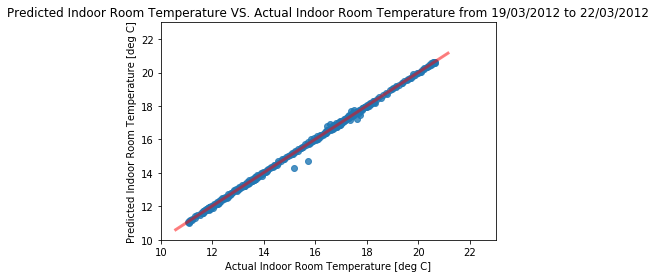

In [56]:
Fig = plt.figure("Actual Vs Prediction with LR")
ax1 = Fig.add_subplot(111)
plot = sns.regplot(x="Real", y="Predicted",
                   data=DF_IndoorTemperaturePrediction,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Predicted Indoor Room Temperature VS. Actual Indoor Room Temperature from 19/03/2012 to 22/03/2012')
plot.set_xlim([10,23])                                                                  
plot.set_ylim([10,23])                   
plot.set_xlabel('Actual Indoor Room Temperature [deg C]')
plot.set_ylabel('Predicted Indoor Room Temperature [deg C]')
regline = plot.get_lines()[0];
regline.set_color('red')
plt.show()

One can see that also in this case, the prediction is really accurate, except for few points which are not well predicted.

Let's now do the same thing, but using Random Forest technique.

In [59]:
DF_IndoorTemperaturePrediction = pd.DataFrame(index = DF_Lagged.index)
Period_of_training = pd.Timedelta(4, unit ="d")
FirstTimeStamp_measured = DF_Lagged.index[0]
LastTimeStamp_measured = DF_Lagged.index[-1]                                                     
FirstTimeStamp_toPredict = FirstTimeStamp_measured + Period_of_training
Training_startTimeStamp = FirstTimeStamp_measured
Trainig_endTimeStamp = FirstTimeStamp_toPredict                                             
TimeStamp_toPredict = FirstTimeStamp_toPredict
DF_IndoorTemperaturePrediction = DF_IndoorTemperaturePrediction.truncate(before = Trainig_endTimeStamp)

In [60]:
while (TimeStamp_toPredict < LastTimeStamp_measured):
    DF_feature_train = DF_Features.truncate(before = Training_startTimeStamp, after = Trainig_endTimeStamp)         # tronca tutto quello prima di before e tutto quello dopo after
    DF_target_train = DF_Target.truncate(before = Training_startTimeStamp, after = Trainig_endTimeStamp)
    DF_feature_test = DF_Features.loc[TimeStamp_toPredict].values.reshape(1,-1)
    DF_target_test = DF_Target.loc[TimeStamp_toPredict]
    reg_RF.fit(DF_feature_train,DF_target_train)
    Predicted_Temperature = reg_RF.predict(DF_feature_test)
    DF_IndoorTemperaturePrediction.loc[TimeStamp_toPredict,"Predicted"] = Predicted_Temperature
    DF_IndoorTemperaturePrediction.loc[TimeStamp_toPredict,"Real"] = DF_target_test
    TimeStamp_toPredict = TimeStamp_toPredict + pd.Timedelta(15, unit = "m")
    Trainig_endTimeStamp = Trainig_endTimeStamp + pd.Timedelta(15, unit = "m")
    Training_startTimeStamp = Training_startTimeStamp + pd.Timedelta(15, unit = "m")

DF_IndoorTemperaturePrediction.dropna(inplace = True)

Let's see the R2 value of this case.

In [61]:
R2_score_continuous_RF = r2_score(DF_IndoorTemperaturePrediction[["Real"]],DF_IndoorTemperaturePrediction[["Predicted"]])
print("R2 value: "+str(R2_score_continuous_RF))

R2 value: 0.999000635014


In this case, R2 value is even better than in the previous one.

In [62]:
DF_IndoorTemperaturePrediction.head()

,Predicted,Real
Date_Time,,
2012-03-19 06:00:00,17.52773,17.5080
2012-03-19 06:15:00,17.50402,17.4167
2012-03-19 06:30:00,17.36660,17.2840
2012-03-19 06:45:00,17.14097,17.1513
2012-03-19 07:00:00,17.10393,17.0500


In [63]:
DF_IndoorTemperaturePrediction.tail()

,Predicted,Real
Date_Time,,
2012-03-22 22:30:00,16.50384,16.4973
2012-03-22 22:45:00,16.39290,16.3847
2012-03-22 23:00:00,16.30669,16.2967
2012-03-22 23:15:00,16.21044,16.1993
2012-03-22 23:30:00,16.07638,16.1033


I'm now plotting the behaviour of this model.

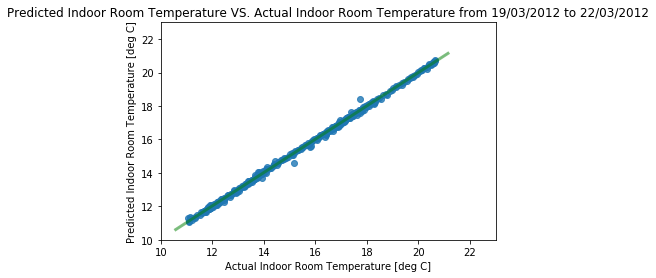

In [64]:
Fig = plt.figure("Actual Vs Prediction with RF")
ax1 = Fig.add_subplot(111)
plot = sns.regplot(x="Real", y="Predicted",
                   data=DF_IndoorTemperaturePrediction,ax=ax1,
                   line_kws={"lw":3,"alpha":0.5})
plt.title('Predicted Indoor Room Temperature VS. Actual Indoor Room Temperature from 19/03/2012 to 22/03/2012')
plot.set_xlim([10,23])                                                                  
plot.set_ylim([10,23])                   
plot.set_xlabel('Actual Indoor Room Temperature [deg C]')
plot.set_ylabel('Predicted Indoor Room Temperature [deg C]')
regline = plot.get_lines()[0];
regline.set_color('green')
plt.show()

Also from a graphic point of view, one can see that this last model predict very well the actual values, and is the best among the model used till now.